# Training Classifier Models and Outlier Detection

In [1]:
from sklearn.model_selection import train_test_split
import optuna
from sklearn.linear_model import LogisticRegression
from lightgbm import LGBMClassifier
from sklearn.metrics import balanced_accuracy_score
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
import sys
sys.path.append("../")

import cfmining.models as models
from cfmining.outlier_detector import *
from cfmining.datasets import *

import os
import joblib

%load_ext autoreload
%autoreload 2

/home/giovani.valdrighi/miniconda3/envs/p2ce/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

## General Configs

In [3]:
VAL_RATIO = 1/10
TEST_RATIO = 0.5
SEED = 0
n_jobs = 8
n_trials = 50

In [4]:
hyperparam_spaces = {
    "LogisticRegression" : {
        "C": {"low": 1e-5, "high": 1, "log": True, "type": "float"},
        "class_weight": {"choices": ["balanced"], "type": "categorical"},
        "random_state" : {"choices": [SEED], "type": "categorical"},
        "max_iter" : {"low" : 1000, "high" : 1000, "type" : "int"},
    },
    "LGBMClassifier": {
        "n_estimators": {"low": 5, "high": 250, "type": "int"},
        "learning_rate": {"low": 0.05, "high": 1.0, "type": "float"},
        "max_depth": {"low": 2, "high": 12, "type": "int"},
        "colsample_bytree": {"low": 0.1, "high": 1.0, "type": "float"},
        "reg_lambda": {"low": 1e-2, "high": 1e4, "log": True, "type": "float"},
        "verbose": {"choices": [-1], "type": "categorical"},
        "random_state" : {"choices": [SEED], "type": "categorical"},
    },
    "LGBMClassifier_simple": {
        "n_estimators": {"low": 5, "high": 250, "type": "int"},
        "learning_rate": {"low": 0.05, "high": 1.0, "type": "float"},
        "max_depth": {"low": 2, "high": 12, "type": "int"},
        "colsample_bytree": {"low": 0.1, "high": 1.0, "type": "float"},
        "reg_lambda": {"low": 1e-2, "high": 1e4, "log": True, "type": "float"},
        "verbose": {"choices": [-1], "type": "categorical"},
        "random_state" : {"choices": [SEED], "type": "categorical"},
    },
    "SVC" : {
        "C": {"low": 1e-7, "high": 1e-2, "log": True, "type": "float"},
        "class_weight": {"choices": ["balanced"], "type": "categorical"},
        "random_state" : {"choices": [SEED], "type": "categorical"},
        #"probability" : {"choices": [True], "type": "categorical"},
    },
    "MLPClassifier": {
        "hidden_layer_sizes": {
            "choices": [
                [30],
                [30, 30],
                [30, 30, 30],
                [64],
                [30, 64],
            ],
            "type": "categorical",
        },
        "learning_rate_init": {"low": 1e-5, "high": 1e-3, "type": "float", "log": True},
        "weight_decay": {"low": 1e-5, "high": 1e-3, "type": "float", "log": True},
        #"epochs": {"low": 100, "high": 101, "type": "int", "step": 10},
        "class_weight": {"choices": ["balanced"], "type": "categorical"},
        "batch_size" : {"low" : 128, "high" : 128, "type" : "int"},
        "random_state" : {"choices": [SEED], "type": "categorical"},
    },
}

In [5]:
optuna.logging.set_verbosity(optuna.logging.WARNING)

def get_model(X, model_name, categorical_features, params):
    num_features = [col for col in X.columns if col not in categorical_features]

    # ordinal_encoder_pip = ColumnTransformer(
    #     [
    #         ("num", "passthrough", num_features),
    #         ("cat", 
    #         OrdinalEncoder(
    #             dtype=np.int64, 
    #             handle_unknown="use_encoded_value", 
    #             unknown_value=-1, 
    #             encoded_missing_value=-1), 
    #         categorical_features)
    #     ], 
    #     verbose_feature_names_out=False
    # )
    # ordinal_encoder_pip.set_output(transform="pandas")
    one_hot_encoder_pip = ColumnTransformer(
        [
            #("num", "passthrough", num_features),
            ("num", StandardScaler(), num_features),
            ("cat", OneHotEncoder(sparse_output=False), categorical_features)
        ], 
        verbose_feature_names_out=False
    )
    one_hot_encoder_pip.set_output(transform="pandas")
    model = [
        #("tranform_to_num", ordinal_encoder_pip),
        ("preprocess", one_hot_encoder_pip),
    ]   
    if model_name == "LGBMClassifier":
        model.append(("classifier", LGBMClassifier(**params)))
        model = Pipeline(model)
    elif model_name == "LGBMClassifier_simple":
        model = LGBMClassifier(**params)
    elif model_name == "SVC":
        model.append(("classifier", models.SVC(**params)))
        model = Pipeline(model)
    elif model_name == "MLPClassifier":
        model.append(("classifier", models.MLPClassifier(**params)))
        model = Pipeline(model)
    elif model_name == "LogisticRegression":
        model.append(("classifier", LogisticRegression(**params)))
        model = Pipeline(model)
    return model


def objective(
    trial,
    hyperparams,
    X_train,
    Y_train,
    X_val,
    Y_val,
    model_name = "LGBMClassifier",
    categorical_features = [],
    ):
    params = {}
    for k, v in hyperparams.items():
        if v["type"] == "categorical":
            params[k] = trial.suggest_categorical(k, v["choices"])
        elif v["type"] == "int":
            params[k] = trial.suggest_int(k, v["low"], v["high"])
        elif v["type"] == "float":
            params[k] = trial.suggest_float(k, v["low"], v["high"], log=v.get("log", False))

    model = get_model(X_train, model_name, categorical_features, params)
    model.fit(X_train, Y_train)

    Y_val_pred = model.predict(X_val)
    score = balanced_accuracy_score(Y_val, Y_val_pred)

    return score

In [7]:
model_list = [
    #"LogisticRegression",
    #"SVC",
    #"LGBMClassifier",
    #"LGBMClassifier_simple",
    "MLPClassifier",
]
dataset_list = [
    #"german",
    #"german_cat",
    #"taiwan",
    #"taiwan_cat",
    #"adult",
    #"adult_cat",
    "homecredit",
    "acsincome",
]

for dataset_name in dataset_list:

    #### LOAD DATA
    os.makedirs(f"../models/{dataset_name}", exist_ok=True)
    cat = "_cat" in dataset_name

    dataset = DATASETS_[dataset_name.replace("_cat", "")](use_categorical=cat)
    X, Y = dataset.load_data()

    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=TEST_RATIO, random_state=SEED, shuffle=True)
    X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size=VAL_RATIO, random_state=SEED, shuffle=True)

    # reset index
    X_train = X_train.reset_index(drop=True)
    X_val = X_val.reset_index(drop=True)
    X_test = X_test.reset_index(drop=True)
    Y_train = Y_train.reset_index(drop=True)
    Y_val = Y_val.reset_index(drop=True)
    Y_test = Y_test.reset_index(drop=True)

    #if dataset_name == "homecredit":
        #hyperparam_spaces["MLPClassifier"]["hidden_layer_sizes"]["choices"] = [
        #    [64], [64, 64], [64, 64, 64], 
        #]
        
    #### HYPERPARAMETER OPTIMIZATION OF EACH MODEL
    for model_name in model_list:
        if "cat" in dataset_name and model_name == "LGBMClassifier_simple":
            continue
        study = optuna.create_study(
        direction="maximize",
        )
        study.optimize(
            lambda trial: objective(trial, hyperparam_spaces[model_name], X_train, Y_train, X_val, Y_val, model_name, dataset.categoric_features),
            n_trials=n_trials,
            n_jobs=n_jobs if model_name != "MLPClassifier" else 1,
            show_progress_bar=True,
        )

        params = study.best_params
        model = get_model(X_train, model_name, dataset.categoric_features, params)
        
        model.fit(X_train, Y_train)
        Y_train_pred = model.predict(X_train)
        Y_test_pred = model.predict(X_test)

        print(f"Number of denied samples from test: {(1 - Y_test_pred).sum():.0f}")
        print(f"Score  training: {balanced_accuracy_score(Y_train, Y_train_pred):.3f}")
        print(f"Score validation: {study.best_value:.3f}")
        print(f"Score test: {balanced_accuracy_score(Y_test, Y_test_pred):.3f}")

        joblib.dump(model, f"../models/{dataset_name}/{model_name}.pkl")


    
    #### SAVE ISOLATION FOREST
    outlier_detection = IsolationForest(contamination = dataset.outlier_contamination, ndim=1, sample_size=0.25, max_depth="auto", ntrees=100, missing_action="divide")
    outlier_detection.fit(X_train);
    joblib.dump(outlier_detection, f"../models/{dataset_name}/IsolationForest.pkl")

    outlier_detection = IsolationForest(dataset.outlier_contamination, ndim=1, sample_size=0.25, max_depth="auto", ntrees=100)
    outlier_detection.fit(X_test);
    joblib.dump(outlier_detection, f"../models/{dataset_name}/IsolationForest_test.pkl")


    #### SAVE AE OUTLIER DETECTOR
    outlier_detection = AE_OutlierDetector(
        categoric_features=dataset.categoric_features,
        contamination=dataset.outlier_contamination,
        hidden_layer_sizes = [128, 64, 64, 64],
    )
    outlier_detection.fit(X_train);
    joblib.dump(outlier_detection, f"../models/{dataset_name}/AE_OutlierDetection.pkl")

    outlier_detection = AE_OutlierDetector(
        categoric_features=dataset.categoric_features,
        contamination=dataset.outlier_contamination,
        hidden_layer_sizes = [128, 64, 64, 64],
    )
    #outlier_detection.fit(X_test);
    joblib.dump(outlier_detection, f"../models/{dataset_name}/AE_OutlierDetection_test.pkl")

Best trial: 23. Best value: 0.671116: 100%|█████████████████████████████████████████████████████████████████████████████████| 50/50 [22:23<00:00, 26.87s/it]


Number of denied samples from test: 15490
Score  training: 0.701
Score validation: 0.671
Score test: 0.672


Best trial: 12. Best value: 0.75895: 100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [14:29<00:00, 17.38s/it]


Number of denied samples from test: 12752
Score  training: 0.757
Score validation: 0.759
Score test: 0.756


## Analysis of Outlier Detectors

In [2]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import matplotlib
matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.family'] = 'STIXGeneral'
# use the seaborn whitegrid style
plt.style.use('seaborn-v0_8-whitegrid')

german & 0.48 & 0.57 & 0.48 & 0.57 \\
taiwan & 0.42 & 0.52 & 0.42 & 0.51 \\
adult & 0.42 & 0.56 & 0.42 & 0.56 \\
acsincome & 0.48 & 0.60 & 0.48 & 0.59 \\
homecredit & 0.40 & 0.48 & 0.39 & 0.47 \\


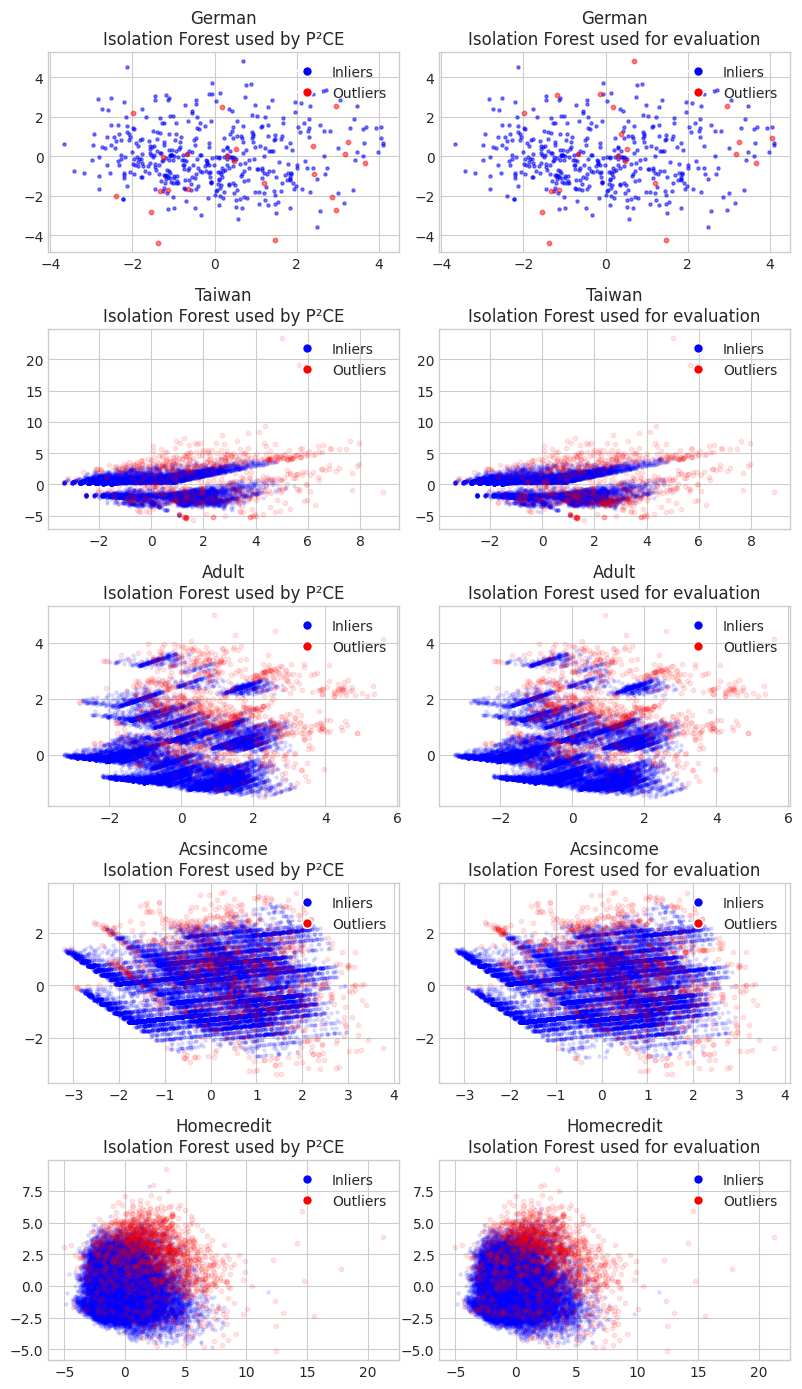

In [73]:
fig, axs = plt.subplots(nrows = 5, ncols = 2, figsize = (8, 14))

for i, dataset_name in enumerate(["german", "taiwan", "adult", "acsincome", "homecredit"]):
    dataset = DATASETS_[dataset_name.replace("_cat", "")](use_categorical=cat)
    X, Y = dataset.load_data()
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=TEST_RATIO, random_state=SEED, shuffle=True)
    X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size=VAL_RATIO, random_state=SEED, shuffle=True)

    with open(f"../models/{dataset_name}/LogisticRegression.pkl", "rb") as f:
        model = joblib.load(f)

    with open(f"../models/{dataset_name}/IsolationForest.pkl", "rb") as f:
        outlier_detection = joblib.load(f)

    with open(f"../models/{dataset_name}/IsolationForest_test.pkl", "rb") as f:
        outlier_detection_test = joblib.load(f)


    X_train_transformed = model[0].transform(X_train)
    pca = PCA(n_components=2)
    #pca = TSNE(n_components=2, random_state=SEED, init='random', learning_rate='auto')
    X_train_pca = pca.fit_transform(X_train_transformed)
    outliers = outlier_detection.predict(X_train)
    outliers_test = outlier_detection_test.predict(X_train)


    print(f"{dataset_name} & {np.mean(outlier_detection.scores):.2f} & {outlier_detection.threshold:.2f} & {np.mean(outlier_detection_test.scores):.2f} & {outlier_detection_test.threshold:.2f} \\\\")

    alpha = 0.1 if len(X_train) > 5000 else 0.5

    #axs[i, 0].scatter(X_train_pca[:, 0], X_train_pca[:, 1], c=outliers, cmap='coolwarm', s=5, alpha = alpha)
    #axs[i, 1].scatter(X_train_pca[:, 0], X_train_pca[:, 1], c=outliers_test, cmap='coolwarm', s=5, alpha = alpha)

    # plot first the inliers
    axs[i, 0].scatter(X_train_pca[outliers == 1, 0], X_train_pca[outliers == 1, 1], color = "blue", s=5, alpha = alpha, label='Inliers', rasterized=True)
    axs[i, 0].scatter(X_train_pca[outliers == -1, 0], X_train_pca[outliers == -1, 1], color='red', s=10, alpha = alpha, label='Outliers', rasterized=True)

    axs[i, 1].scatter(X_train_pca[outliers_test == 1, 0], X_train_pca[outliers_test == 1, 1], color = "blue", s=5, alpha = alpha, label='Inliers', rasterized=True)
    axs[i, 1].scatter(X_train_pca[outliers_test == -1, 0], X_train_pca[outliers_test == -1, 1], color='red', s=10, alpha = alpha, label='Outliers', rasterized=True)
    axs[i, 0].set_title(f"{dataset_name.capitalize()}\nIsolation Forest used by P²CE")
    axs[i, 1].set_title(f"{dataset_name.capitalize()}\nIsolation Forest used for evaluation")

    # add legend only to the first subplot, make legend have background white
    handles = [
        plt.Line2D([0], [0], marker='o', color='w', label='Inliers', markerfacecolor='blue', markersize=7),
        plt.Line2D([0], [0], marker='o', color='w', label='Outliers', markerfacecolor='red', markersize=7),
    ]
    axs[i, 0].legend(handles=handles, loc='upper right', framealpha=1, facecolor='white')
    axs[i, 1].legend(handles=handles, loc='upper right', framealpha=1, facecolor='white')

plt.tight_layout()
plt.savefig("../figures/isolation_forest_outliers.pdf")
    